<a href="https://colab.research.google.com/github/JaimeRoss/Prediction-of-Product-Sales/blob/main/prediction_of_product_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author: Jaime Ross

## Project Overview
The first project will be a sales prediction for food items sold at various stores. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales

#Mounting Drive

In [393]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [394]:
# imports required
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config (transform_output='pandas')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
pd.set_option('display.max_columns', None)

# Load and Inspect Data

In [395]:
# loading and inspecting data

URL = "/content/drive/MyDrive/Student folder for data science bootcamp/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(URL)

In [396]:
#inspecting first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [397]:
# Using .info() to view summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Clean Data

In [398]:
# overview of questions to be addressed:
#-----------------------------------------
# 1) How many rows and columns?
# 2) What are the datatypes of each variable?
# 3) Are there duplicates? If so, drop any duplicates.
# 4) Identify missing values.
# 5) Address the missing values by using a placeholder value.
# 6) Confirm that there are no missing values after addressing them.
# 7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).
# 8) For any numerical columns, obtain the summary statistics of each (min, max, mean).
#-----------------------------------------

In [399]:
# 1) How many rows and columns?
df.shape

(8523, 12)

## Answer:
There are 8523 rows and 12 columns of data.

In [400]:
# 2) What are the datatypes of each variable?
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Answer:
In this dataset there are 3 data types namely:
- object
- float64
- int64

In [401]:
# 3) Are there duplicates? If so, drop any duplicates.

# Checking for duplicated data
df.duplicated().sum()

0

## Answer:
There are no duplicate entries in this dataset.

In [402]:
# 4) Identify missing values.
Missing_val = df.isna().sum()
Missing_val

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [403]:
# Calculating the percentage of missing values for each column.
Missing_val / len(df)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

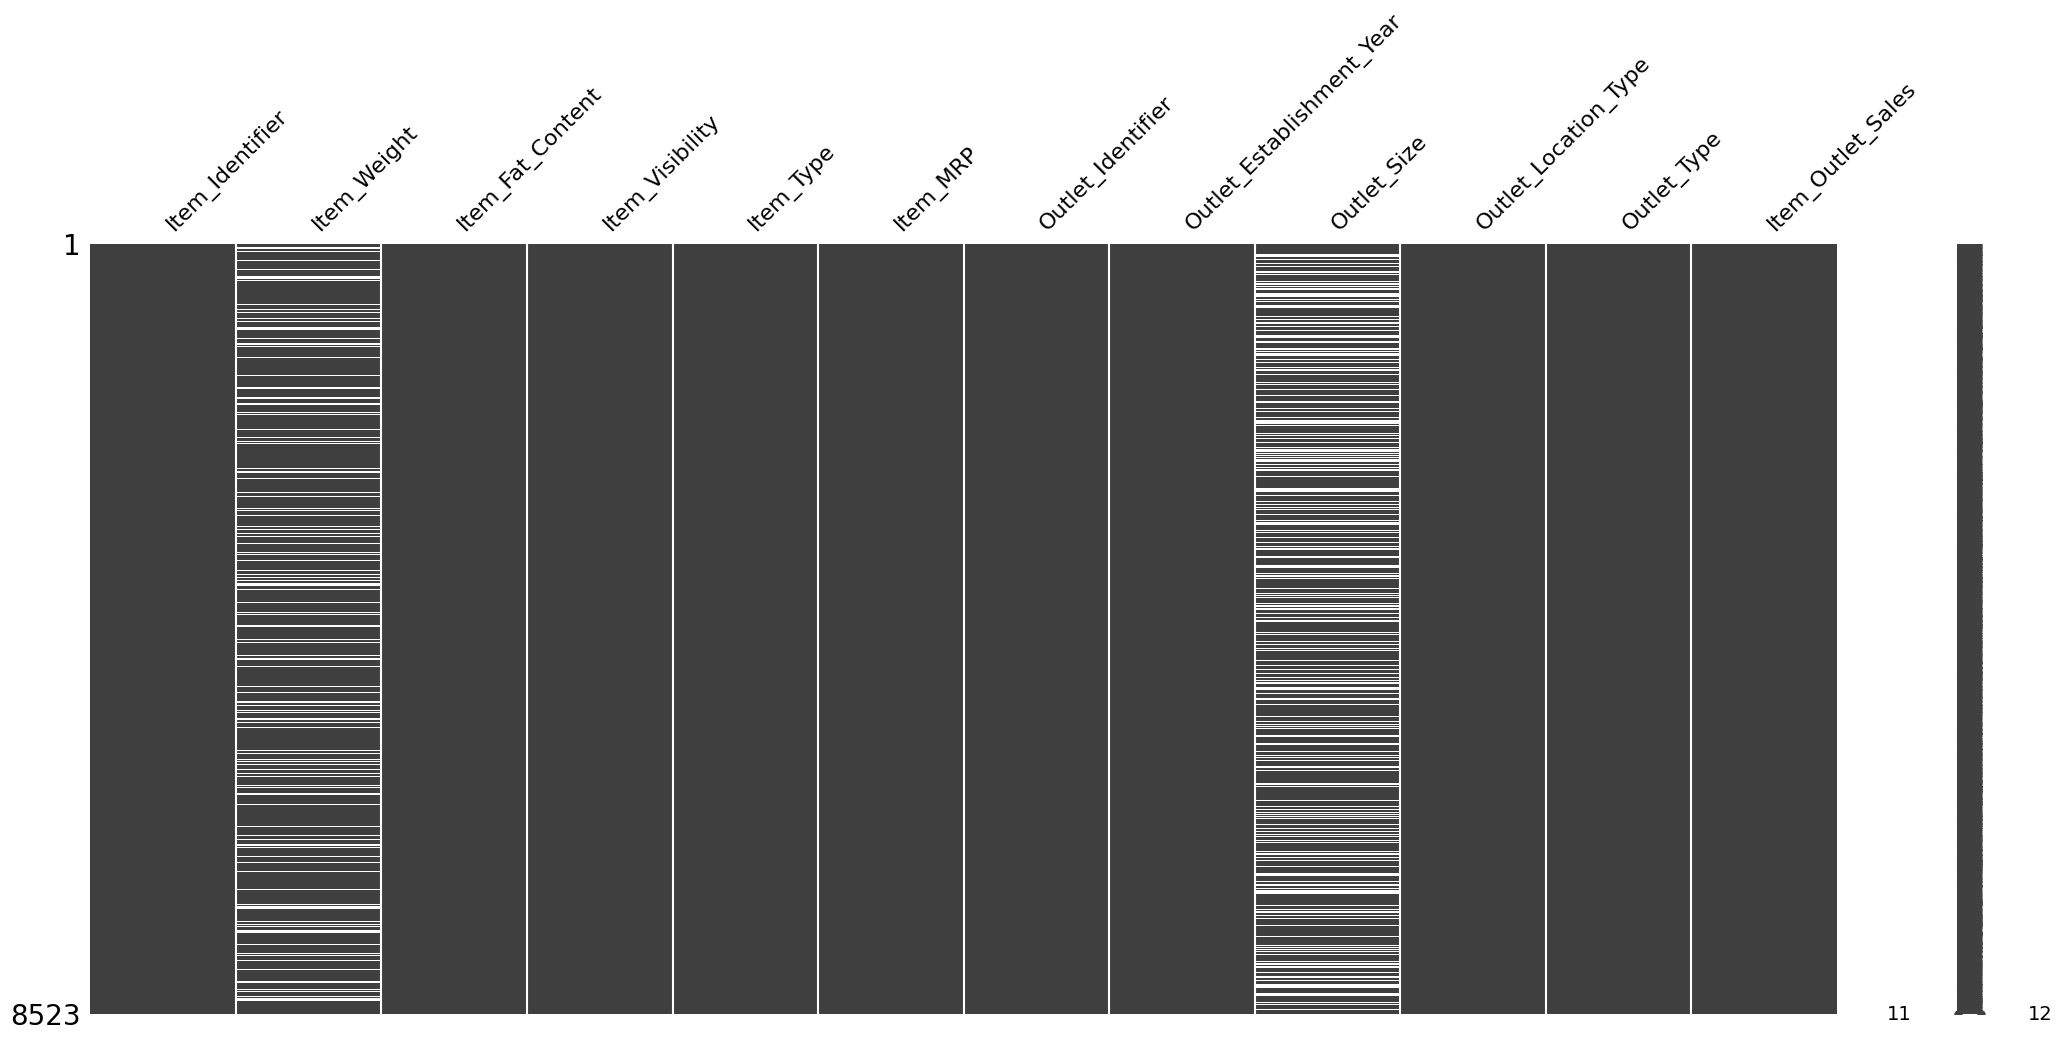

In [404]:
# Getting a visual representation of the missing data using missingno.
msno.matrix(df);

## Answer:
There are missing values in the Item_Weight and Outlet_Size columns.

In [405]:
# 5) Address the missing values by using a placeholder value.

# Creating a list of the numerical columns
num_col = df.select_dtypes("number").columns
num_col

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [406]:
# Placeholder for missing data in numerical columns
numerical_placeholder = -1

# Filling in missing values with a placeholder(-1)
df[num_col] = df[num_col].fillna(numerical_placeholder)

In [407]:
# Creating a list of the categorial columns
cat_col = df.select_dtypes("object").columns
cat_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [408]:
# Placeholder for missing data in categorial columns
categorial_placeholder = "MISSING_DATA"

# Filling in missing values with a placeholder(MISSING_DATA)
df[cat_col] = df[cat_col].fillna(categorial_placeholder)

## Answer:

The missing values have been replaced by placeholders (-1) for numerical columns and (MISSING_DATA) for categorial columns.

In [409]:
# 6) Confirm that there are no missing values after addressing them.
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

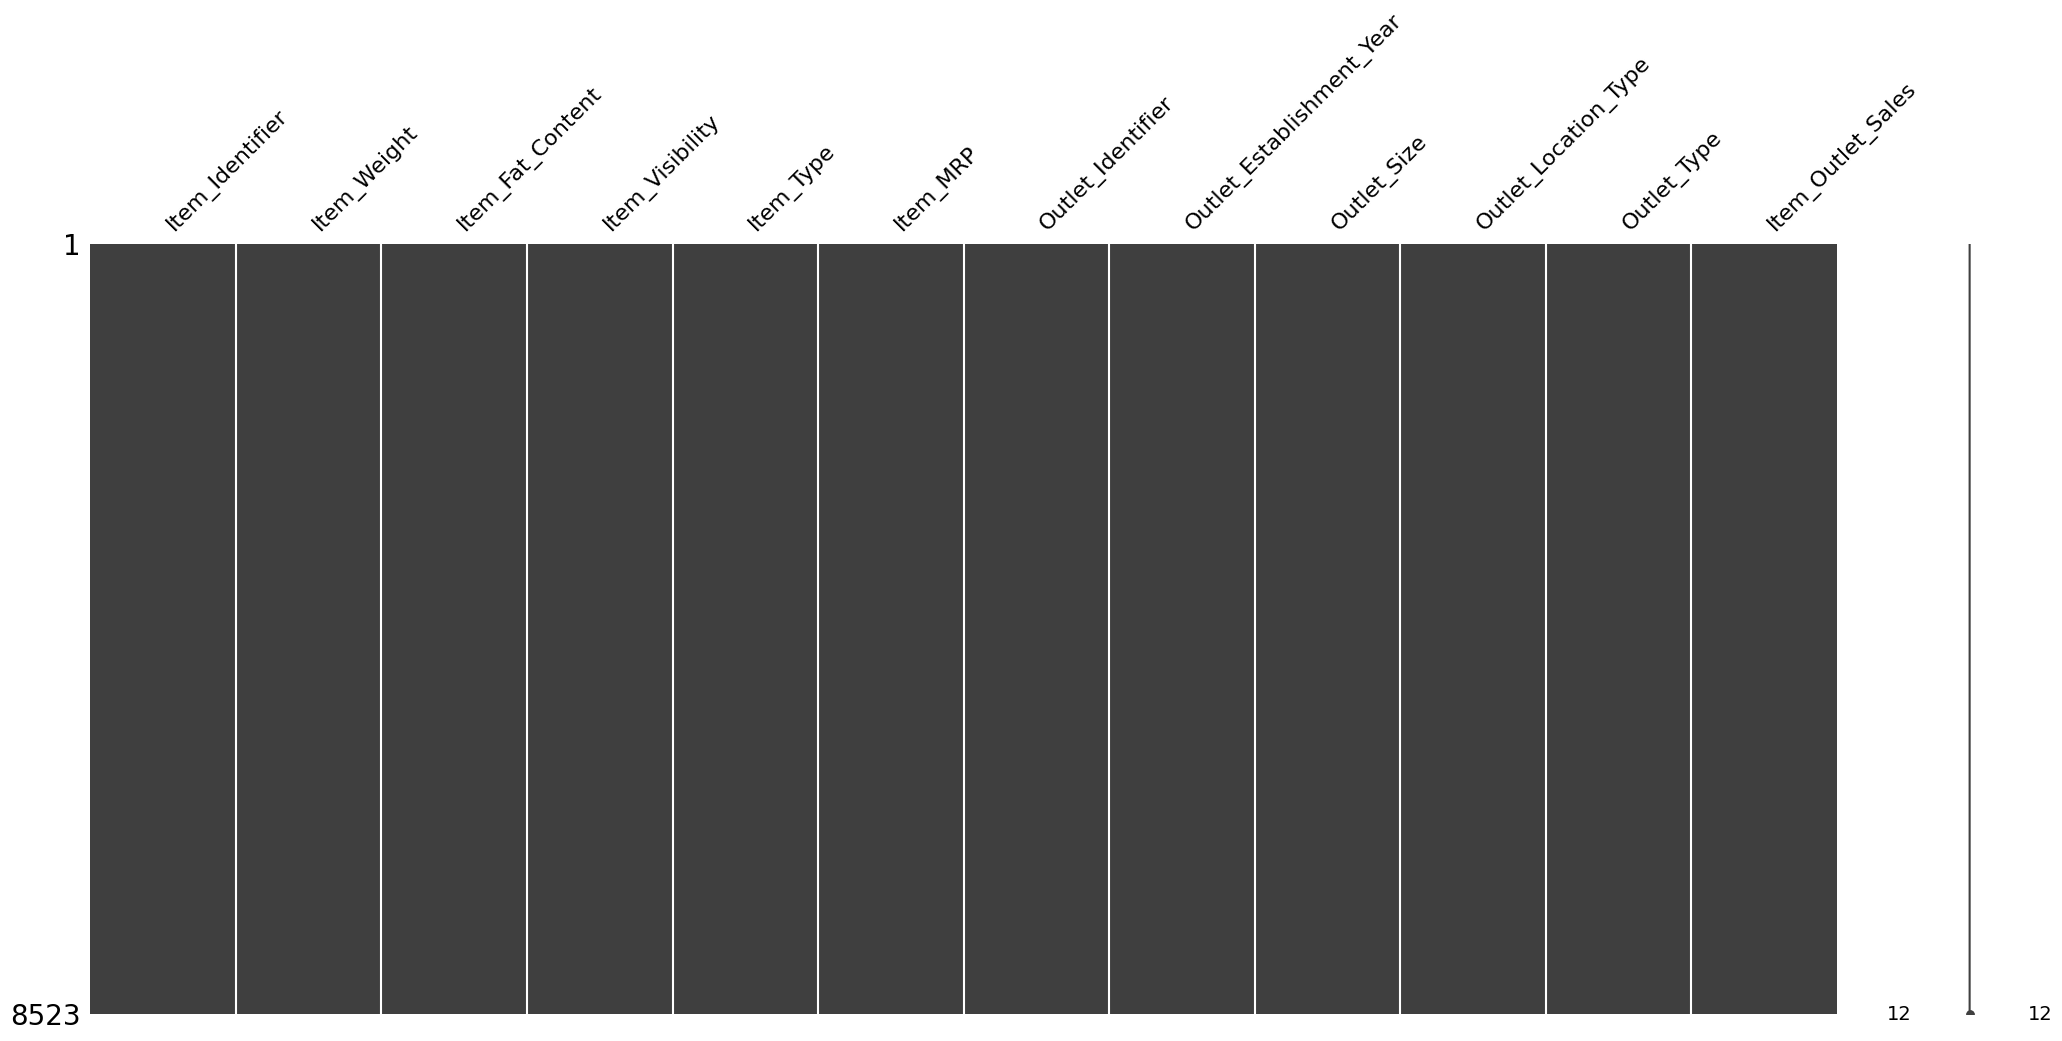

In [410]:
# Using missingno to confirm that there are no more missing values in the dataset.
msno.matrix(df);

## Answer:
There are no more missing values in the dataset.

In [411]:
# 7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).

for column in cat_col:
    # print the value counts for the column
    print(f"Value Counts for {column}")
    print(df[column].value_counts())
  # Print an empty line for readability
    print("\n")

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [412]:
# viewing inconsistency in Item_Fat_Content column
df["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

## Answer:

There is a categorial column that has inconsistent data entries (Item_Fat_Content), the values should be either Low Fat or Regular

In [413]:
# Fixing values in Item_Fat_Content and checking to see if it has been corrected
df["Item_Fat_Content"] = df["Item_Fat_Content"].replace(["LF", "reg","low fat"] , ["Low Fat", "Regular", "Low Fat"])
df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [414]:
# 8) For any numerical columns, obtain the summary statistics of each (min, max, mean).
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,10.48,0.07,140.99,1997.83,2181.29
std,6.72,0.05,62.28,8.37,1706.50
min,-1.00,0.00,31.29,1985.00,33.29
25%,6.65,0.03,93.83,1987.00,834.25
50%,11.00,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [415]:
# Finding Min, Max, Mean
statistics = df.describe()
statistics.loc[["min","max","mean"]]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,-1.000000,0.000000,31.290000,1985.000000,33.290000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800
mean,10.478936,0.066132,140.992782,1997.831867,2181.288914


## Answer:
In our dataset we have a min() value of -1 for our Item_weight, this value is not our minimum value as we had missing values for our numerical column that were replaced with our placeholder(-1). We have a max() value of of 21.35 for our Item_weight. To fix this error in our min() value, we could replace our placeholder value with the average weight to obtain an accurate measure for our min() value.

In [416]:
# fixing min() value for our Item_weight column

mean_weight = df["Item_Weight"].mean()
df["Item_Weight"] = df["Item_Weight"].replace(-1 , mean_weight)
New_Stats = df.describe()
New_Stats.loc[["min","max","mean"]]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.555000,0.000000,31.290000,1985.000000,33.290000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800
mean,12.449332,0.066132,140.992782,1997.831867,2181.288914


In [417]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.449332,0.066132,140.992782,1997.831867,2181.288914
std,4.320272,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,11.000000,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Answer:
We have now fixed the error in our data and have a more acurate value of 4.55 for our min() Item_Weight value.

## Exploratory Data Analysis


#Heatmap

In [418]:
# Getting correlation data
corr = df.corr()
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.030957,0.026032,0.136759,-0.005451
Item_Visibility,-0.030957,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.026032,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,0.136759,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,-0.005451,-0.128625,0.567574,-0.049135,1.000000


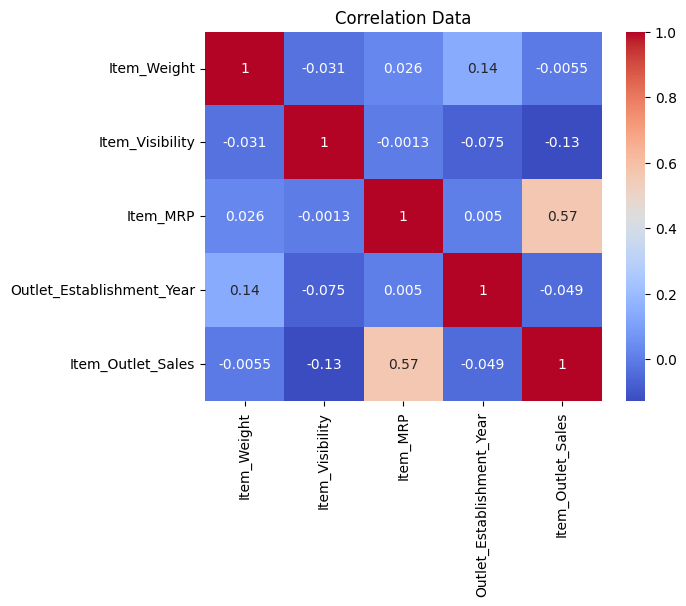

In [419]:
# Creating the heatmap
ax = sns.heatmap(corr, cmap="coolwarm", annot = True)
ax.set_title("Correlation Data");

Looking at the above graph we can see that there is a moderate positive correlation of 0.57 between the Item_MRP and Item_Outlet_Sales features.

#Countplots for categorial columns

In [420]:
# viewing categorial columns
df[cat_col]

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,MISSING_DATA,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,MISSING_DATA,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


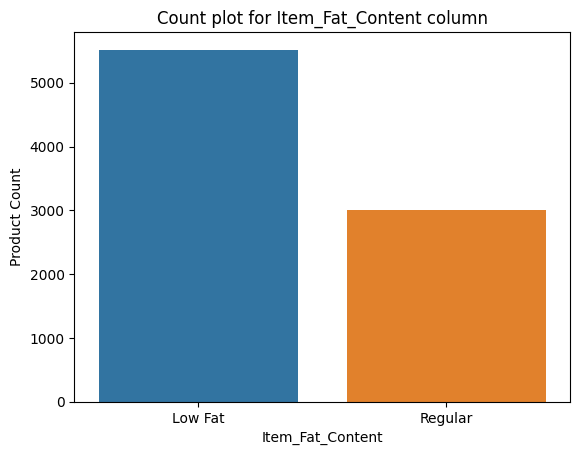

In [421]:
# Creating a countplot for the Item_Fat_content feature
ax = sns.countplot(df, x="Item_Fat_Content")
ax.set_title("Count plot for Item_Fat_Content column")
ax.set_ylabel("Product Count");

Looking at the above graph we can see that there is a higher product count for Low Fat Items

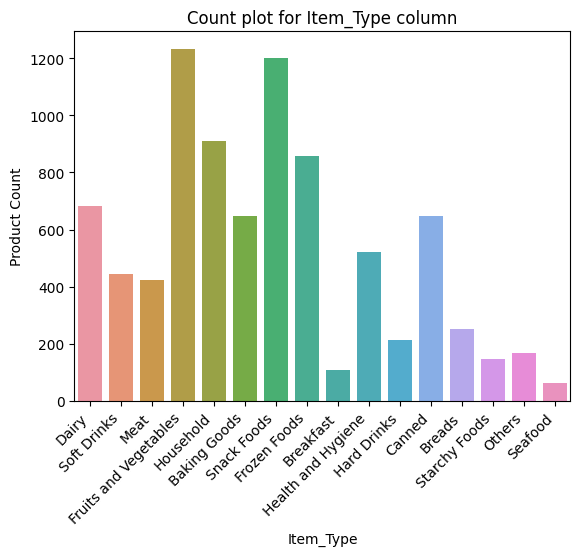

In [422]:
# Creating a countplot for the Item_Type feature
ax = sns.countplot(df, x="Item_Type")
ax.set_title("Count plot for Item_Type column")
ax.set_ylabel("Product Count");
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

The items with the highest product counts are fruits and vegetables, and snack foods. The items with the lowest product count are seafood products and breakfast products.

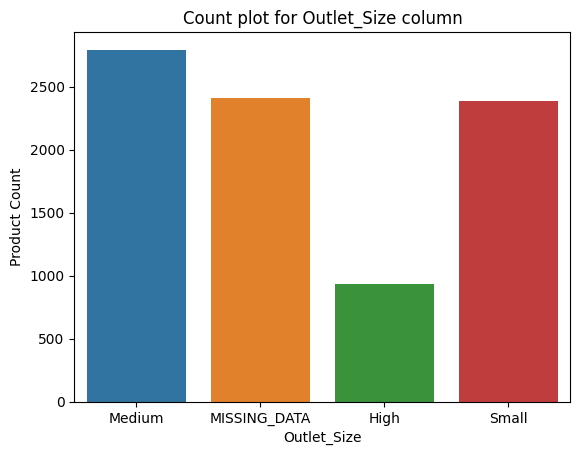

In [423]:
# Creating a countplot for the Outlet_Size feature
ax = sns.countplot(df, x="Outlet_Size")
ax.set_title("Count plot for Outlet_Size column")
ax.set_ylabel("Product Count");

Majority of the stores from the data that is available is medium in size. There are over 2000 entries of missing data in this dataset.

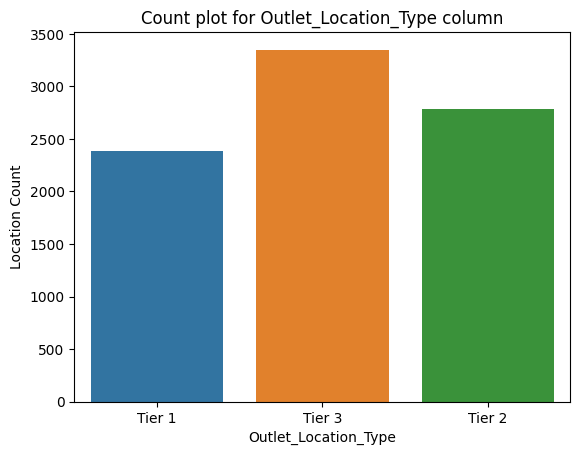

In [424]:
# Creating a countplot for the Outlet_Location_Type feature
ax = sns.countplot(df, x="Outlet_Location_Type")
ax.set_title("Count plot for Outlet_Location_Type column")
ax.set_ylabel("Location Count");

The Tier 3 location has the highest count.

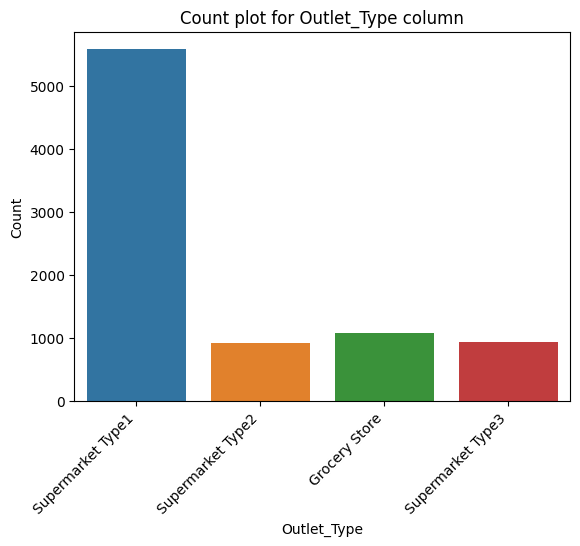

In [425]:
# Creating a countplot for the Outlet_Type feature
ax = sns.countplot(df, x="Outlet_Type")
ax.set_title("Count plot for Outlet_Type column")
ax.set_ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Supermarket Type 1 is the most popular Outlet type.

#Histograms for numerical features:

In [426]:
# Viewing our numerical columns
df[num_col]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.300,0.016047,249.8092,1999,3735.1380
1,5.920,0.019278,48.2692,2009,443.4228
2,17.500,0.016760,141.6180,1999,2097.2700
3,19.200,0.000000,182.0950,1998,732.3800
4,8.930,0.000000,53.8614,1987,994.7052
...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,2778.3834
8519,8.380,0.046982,108.1570,2002,549.2850
8520,10.600,0.035186,85.1224,2004,1193.1136
8521,7.210,0.145221,103.1332,2009,1845.5976


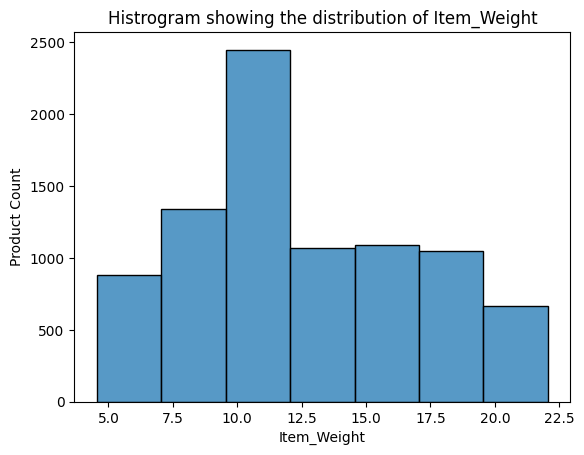

In [427]:
# Creating a histogram for the Item_Weight column
ax = sns.histplot(df, x="Item_Weight", bins="auto", binwidth=2.5)
ax.set_title("Histrogram showing the distribution of Item_Weight")
ax.set_ylabel("Product Count");

The Items with the highest count fall in between the weight category of 10.0-12.0

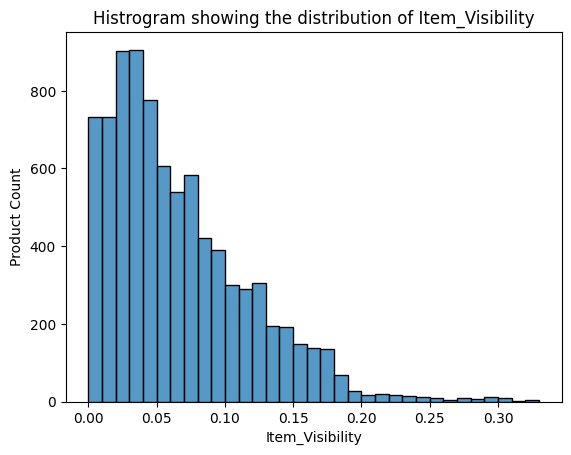

In [428]:
# Creating a histogram for the Item_Visibility column
ax = sns.histplot(df, x="Item_Visibility", bins="auto", binwidth=0.01)
ax.set_title("Histrogram showing the distribution of Item_Visibility")
ax.set_ylabel("Product Count");

The items with the highest visibility are between 0.3-0.4

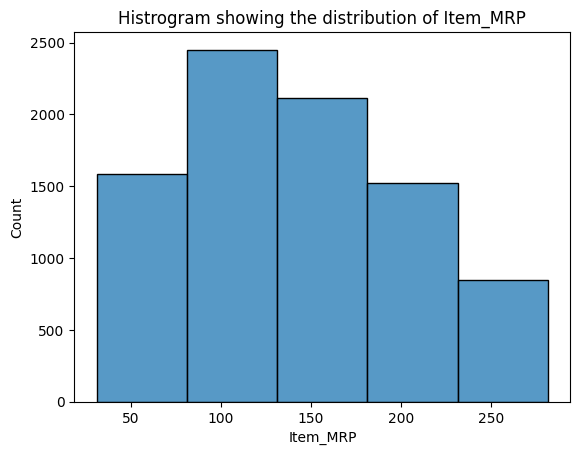

In [429]:
# Creating a histogram for the Item_MRP column
ax = sns.histplot(df, x="Item_MRP", bins="auto", binwidth=50)
ax.set_title("Histrogram showing the distribution of Item_MRP")
ax.set_ylabel("Count");

The most frequent Item_MRP falls between 85 and 135.

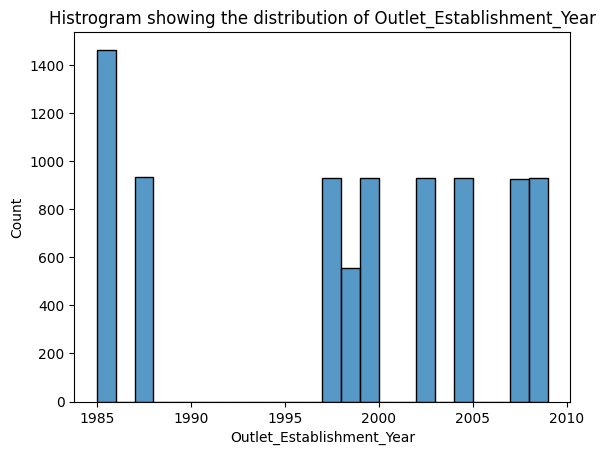

In [430]:
# Creating a histogram for the Outlet_Establishment_Year column
ax = sns.histplot(df, x="Outlet_Establishment_Year", bins="20", binwidth=1)
ax.set_title("Histrogram showing the distribution of Outlet_Establishment_Year")
ax.set_ylabel("Count");

Majority of stores were etablished in 1985. There were no stores established between 1990 and 1995.

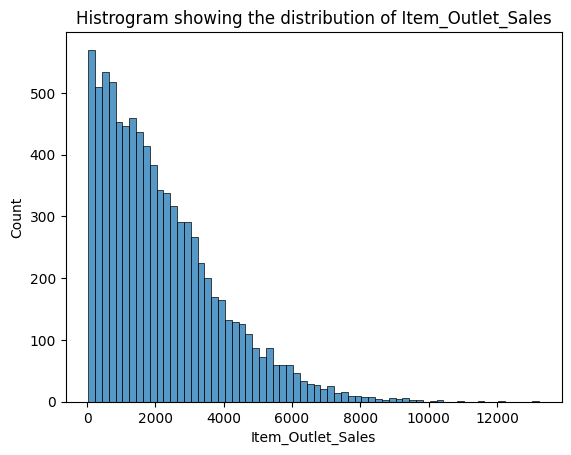

In [431]:
# Creating a histogram for the Item_Outlet_Sales column
ax = sns.histplot(df, x="Item_Outlet_Sales", bins="20", binwidth=200)
ax.set_title("Histrogram showing the distribution of Item_Outlet_Sales")
ax.set_ylabel("Count");

As the sales price increases, the number of items sold decreases. The highest number of sales occur between the price range of 0-2000.

#Boxplots for numerical columns:

In [432]:
# Getting summary of statistics for numerical columns
df[num_col].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.45,0.07,140.99,1997.83,2181.29
std,4.32,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,11.00,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


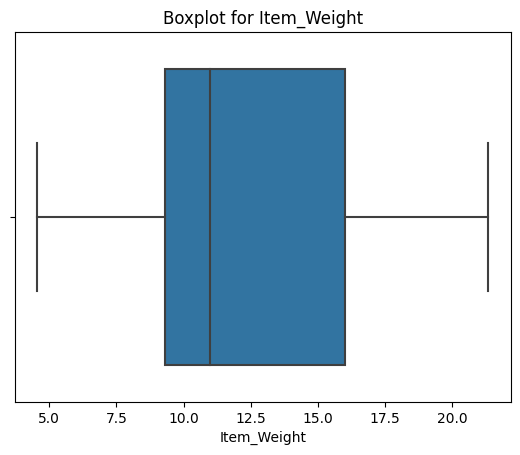

In [433]:
ax = sns.boxplot(df, x="Item_Weight")
ax.set_title("Boxplot for Item_Weight");

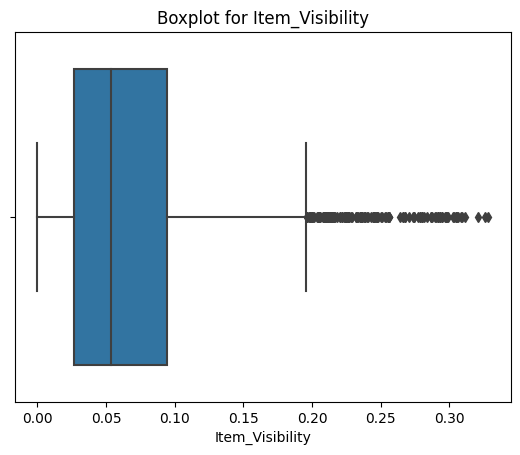

In [434]:
ax = sns.boxplot(df, x="Item_Visibility")
ax.set_title("Boxplot for Item_Visibility");

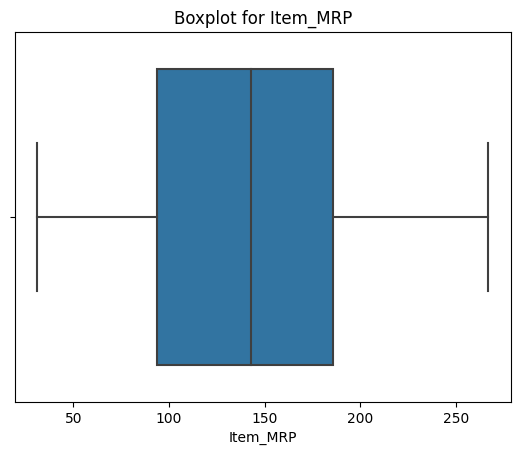

In [435]:
ax = sns.boxplot(df, x="Item_MRP")
ax.set_title("Boxplot for Item_MRP");

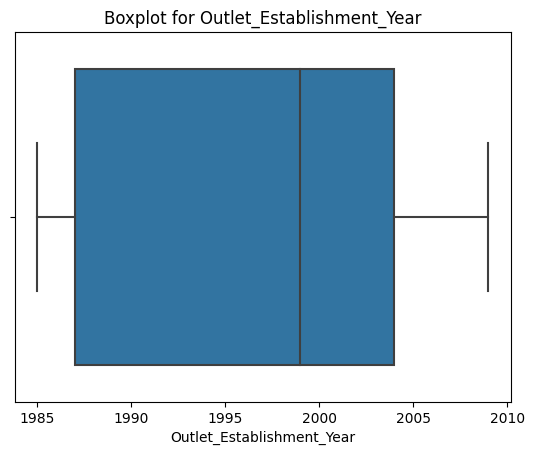

In [436]:
ax = sns.boxplot(df, x="Outlet_Establishment_Year")
ax.set_title("Boxplot for Outlet_Establishment_Year");

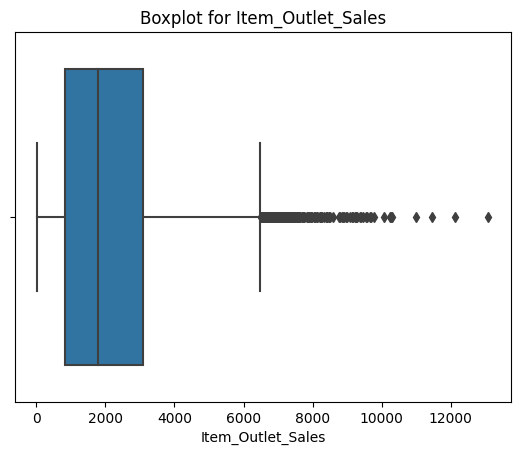

In [437]:
ax = sns.boxplot(df, x="Item_Outlet_Sales")
ax.set_title("Boxplot for Item_Outlet_Sales");

## Explanatory Data Analysis

In [438]:
# Creating my custom function for univariate visualization

def explore_categorical(df, x, fillna = True, figsize = (6,4), order = None):

  # Make a copy of the dataframe and replace placeholder with Null values
  temp_df = df.copy()
  # Before replacing placeholder, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].replace(categorial_placeholder, np.nan)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold');

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [439]:
# Creating my custom function for numerical data to be visualized

def explore_numeric(df, x, figsize=(6,5) ):

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [440]:
# Creating my custom function for Multivariate visualization

def plot_categorical_vs_target(df, x, y="Item_Outlet_Sales", figsize=(6,4), fillna = True, order = None):

  # Make a copy of the dataframe and insert null values
  temp_df = df.copy()
  # Replace placeholder with null values
  if fillna == True:
    temp_df[x] = temp_df[x].replace(categorial_placeholder, np.nan)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax

In [441]:
# Creating a custom function for numeric vs target feature

def plot_numeric_vs_target(df, x, y="Item_Outlet_Sales", figsize=(6,4)):

  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#Item_Fat_Content
Whether the product is low-fat or regular

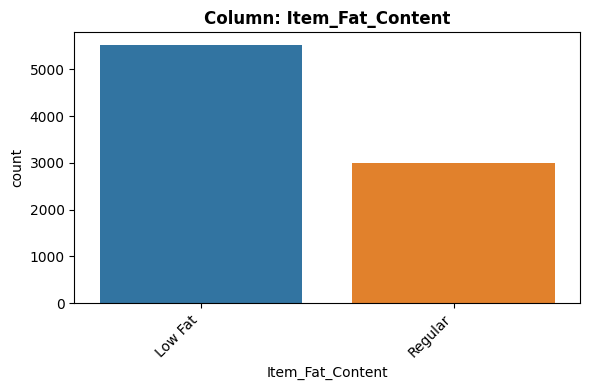

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [443]:
# Univaritate visualization
explore_categorical(df, "Item_Fat_Content");

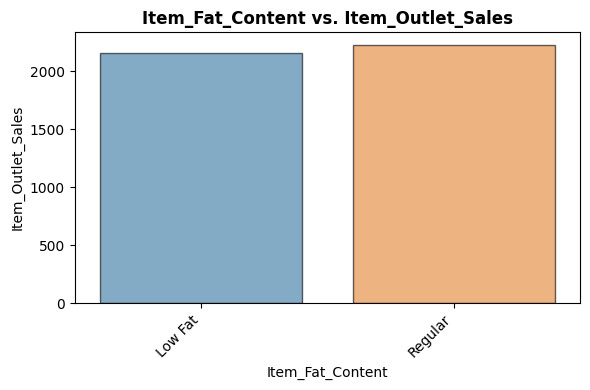

In [444]:
# Multivariate visualization
plot_categorical_vs_target(df,"Item_Fat_Content");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
-Low(2)

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

#Item_Type
The category to which the product belongs

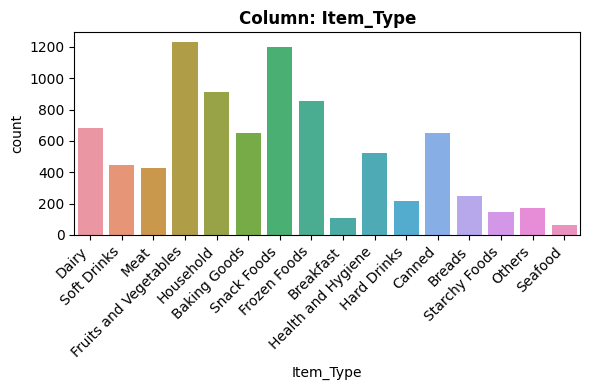

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [445]:
# Univaritate visualization
explore_categorical(df, "Item_Type");

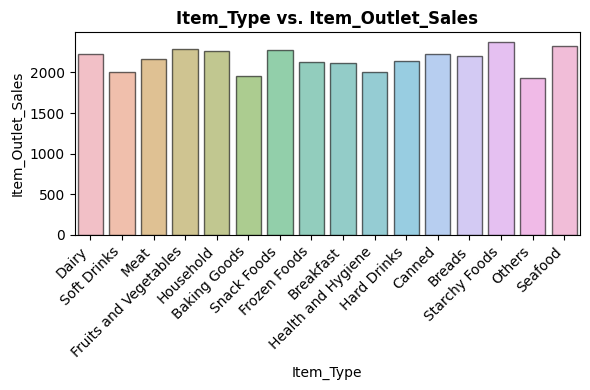

In [446]:
# Multivariate visualization
plot_categorical_vs_target(df,"Item_Type");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- High(16)

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

#Item_MRP
Maximum Retail Price (list price) of the product

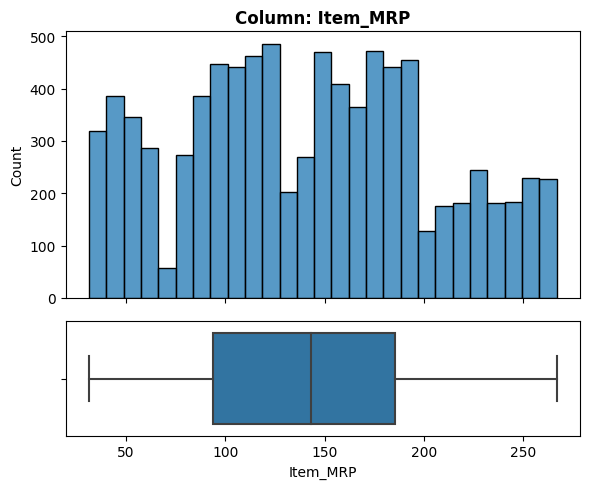

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [447]:
# Univaritate visualization
explore_numeric(df, "Item_MRP");

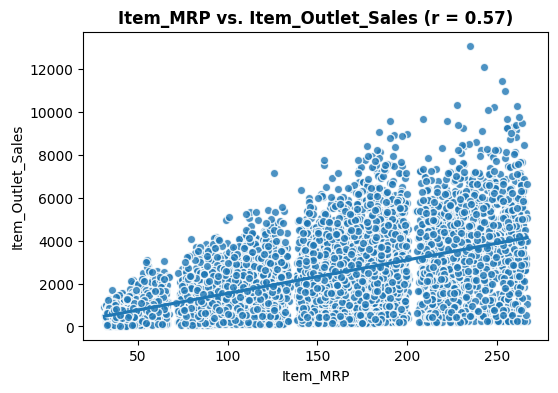

In [448]:
# Multivariate visualization
plot_numeric_vs_target(df,"Item_MRP");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Numeric

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- high()5938

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

#Outlet_Identifier
Store ID

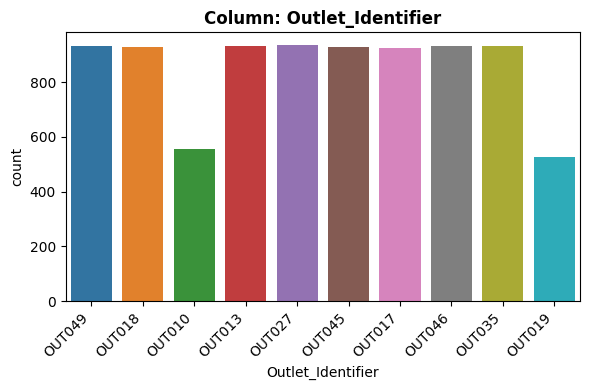

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [449]:
# Univaritate visualization
explore_categorical(df, "Outlet_Identifier");

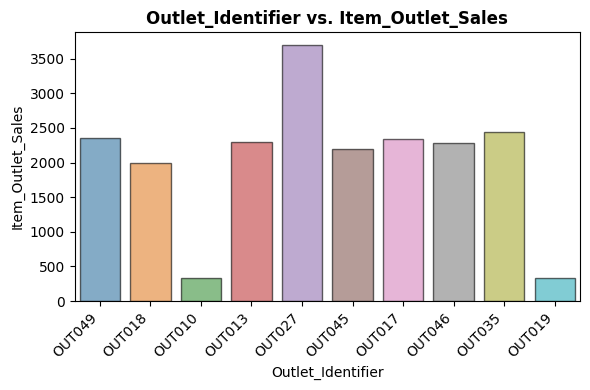

In [450]:
# Multivariate visualization
plot_categorical_vs_target(df,"Outlet_Identifier");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- High

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No, there is not.

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

#Outlet_Establishment_Year
The year in which store was established

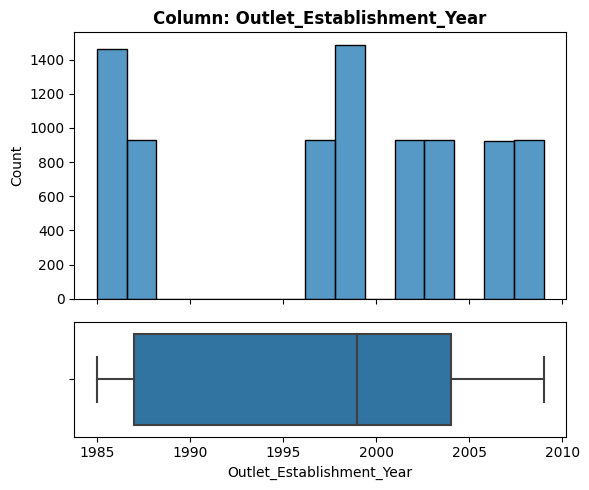

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [451]:
# Univaritate visualization
explore_numeric(df, "Outlet_Establishment_Year");

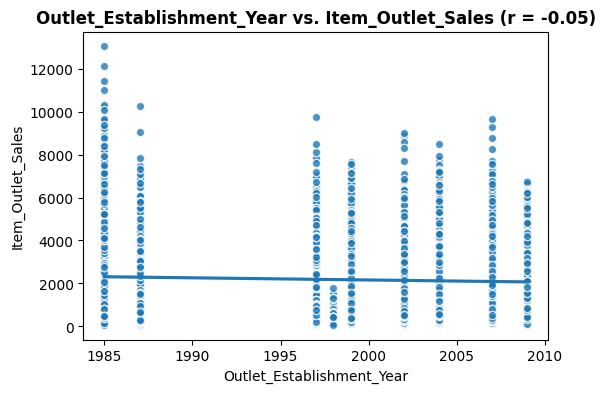

In [452]:
# Multivariate visualization
plot_numeric_vs_target(df,"Outlet_Establishment_Year");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Numeric

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- Low

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

#Outlet_Size
The size of the store in terms of ground area covered

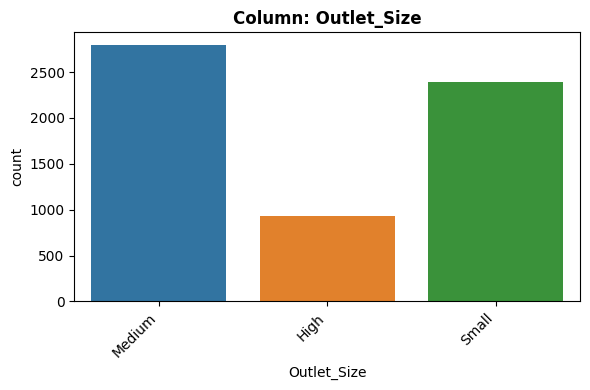

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [453]:
# Univaritate visualization
explore_categorical(df, "Outlet_Size");

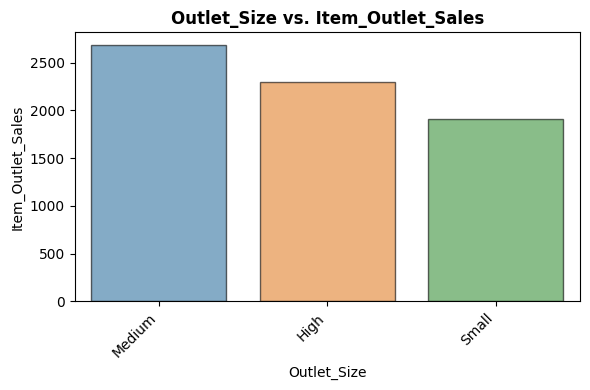

In [454]:
# Multivariate visualization
plot_categorical_vs_target(df,"Outlet_Size");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 2410(28.28%), Impute the missing values with the mean of the outlet size

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- Low(3)

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes, the size of the store plays a role in the prediction of total sales

Does this feature appear to be a predictor of the target?
- Yes

#Outlet_Location_Type
The type of area in which the store is located

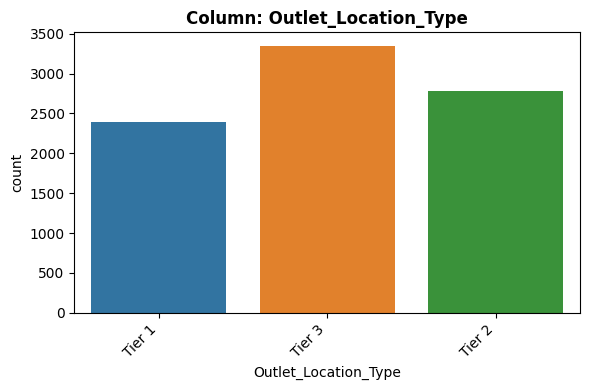

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [455]:
# Univaritate visualization
explore_categorical(df, "Outlet_Location_Type");

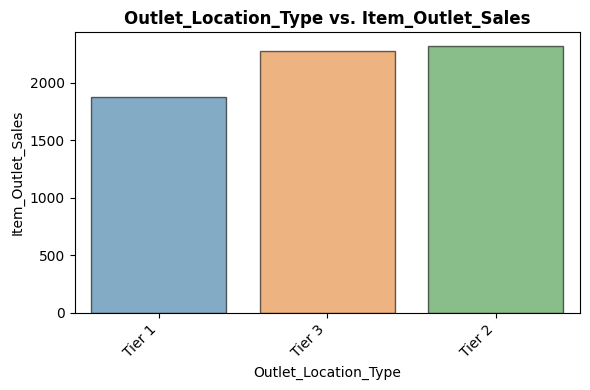

In [456]:
# Multivariate visualization
plot_categorical_vs_target(df,"Outlet_Location_Type");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
- No

What is the cardinality? Is it high (>10)?
- Low(3)

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- yes

#Outlet_Type
Whether the outlet is a grocery store or some sort of supermarket

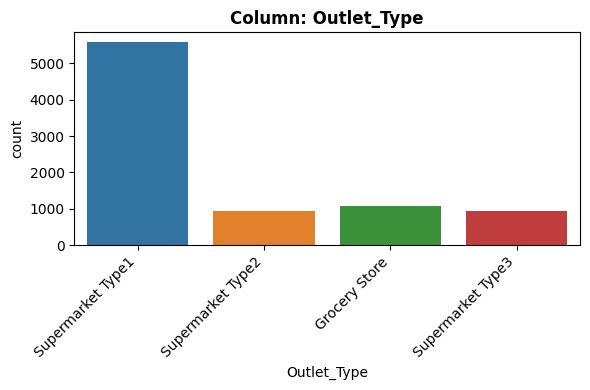

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [457]:
# Univaritate visualization
explore_categorical(df, "Outlet_Type");

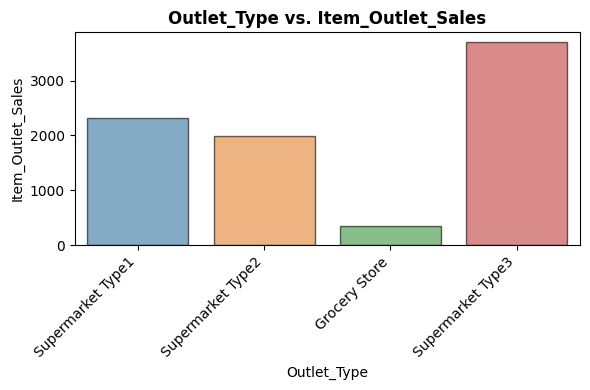

In [458]:
# Multivariate visualization
plot_categorical_vs_target(df,"Outlet_Type");

What type of feature is it? (Categorical (nominal), ordinal, numeric)
- Categorical

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
- 0

Is the feature constant or quasi-constant?
-No

What is the cardinality? Is it high (>10)?
- Low(4)

Would we know this feature before the target is determined?
- Yes

Is there a business case/understanding reason to exclude based on our business case?
- No

Based on your business understanding, would you expect this feature to be a predictor of the target?
- Yes

Does this feature appear to be a predictor of the target?
- Yes

# Preparing data for ML

In [459]:
# Loading uncleaned data set

UURL = "/content/drive/MyDrive/Student folder for data science bootcamp/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
ddf = pd.read_csv(UURL)
ddf.info()
ddf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [460]:
# checking for duplicates

ddfduplicates = ddf.duplicated().sum()
print(f"There are {ddfduplicates} duplicates in this set")

There are 0 duplicates in this set


In [461]:
# checking for inconsistencies in categorical data
categcols = ddf.select_dtypes("object").columns

for column in categcols:
    print(f"value counts for: {column}")
    print(ddf[column].value_counts())
    print("\n")

value counts for: Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


value counts for: Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


value counts for: Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


value counts for: Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    

In [462]:
# fixing inconsistencies for Item_fat_content
ddf["Item_Fat_Content"] = ddf["Item_Fat_Content"].replace(["LF", "reg","low fat"] , ["Low Fat", "Regular", "Low Fat"])
ddf["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [463]:
# Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.
# Perform a train test split

X = ddf.drop(columns = "Item_Outlet_Sales")
Y = ddf["Item_Outlet_Sales"]

# dropping unwanted columns
bad_col = ["Outlet_Identifier","Item_Identifier","Outlet_Establishment_Year"]
X = X.drop(columns = bad_col)

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

In [464]:
# Create a preprocessing object to prepare the dataset for Machine Learning

numcol = make_column_selector(dtype_include = "number")
catcol = make_column_selector(dtype_include = "object")

# creating a standard scaler for numeric columns
scaler = StandardScaler()

# creating a onehot encoder for categorical columns
ohe = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

# creating an imputer for numeric columns
numimputer = SimpleImputer(strategy = "mean")

# creating an imputer for categorical columns
catimputer = SimpleImputer(strategy = "constant", fill_value="MISSING")

In [465]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,Tier 2,Supermarket Type1


In [466]:
# numerical pipeline
numpipe = make_pipeline(numimputer,scaler)
numpipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [467]:
# categorical pipeline
catpipe = make_pipeline(catimputer,ohe)
catpipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [468]:
# creating tuples for numeric and categorical

numtuple = ("numeric",numpipe,numcol)
cattuple = ("catergorical",catpipe,catcol)

# creating the column transformer

col_transformer = ColumnTransformer([numtuple,cattuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c2a10>),
                                ('catergorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c3a00>)],
                  verbose_feature_names_out=False)

In [469]:
# Fitting the ColumnTransformer on training data
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c2a10>),
                                ('catergorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c3a00>)],
                  verbose_feature_names_out=False)

In [470]:
# fitting column transformer on X_train and X_test

X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.004931,-0.952591,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.528819,-0.965484,-0.336460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [471]:
X_train_processed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
count,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.0,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00
mean,0.00,-0.00,0.00,0.65,0.35,0.07,0.03,0.01,0.08,0.08,0.1,0.15,0.03,0.06,0.11,0.05,0.02,0.01,0.14,0.05,0.02,0.11,0.28,0.33,0.28,0.27,0.33,0.40,0.12,0.65,0.11,0.11
std,1.00,1.00,1.00,0.48,0.48,0.26,0.16,0.11,0.26,0.27,0.3,0.36,0.16,0.24,0.31,0.21,0.14,0.08,0.35,0.22,0.14,0.31,0.45,0.47,0.45,0.45,0.47,0.49,0.33,0.48,0.31,0.32
min,-1.98,-1.29,-1.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.81,-0.76,-0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,-0.23,0.03,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,0.76,0.56,0.72,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00
max,2.00,5.13,1.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [480]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Item_Fat_Content_Low Fat         6392 non-null   float64
 4   Item_Fat_Content_Regular         6392 non-null   float64
 5   Item_Type_Baking Goods           6392 non-null   float64
 6   Item_Type_Breads                 6392 non-null   float64
 7   Item_Type_Breakfast              6392 non-null   float64
 8   Item_Type_Canned                 6392 non-null   float64
 9   Item_Type_Dairy                  6392 non-null   float64
 10  Item_Type_Frozen Foods           6392 non-null   float64
 11  Item_Type_Fruits and Vegetables  6392 non-null   float64
 12  Item_Type_Hard Dr

In [472]:
# create model piplines

#linear regression model pipeline
linreg = LinearRegression()
linpipe = make_pipeline(col_transformer,linreg)
linpipe.fit(X_train_processed,Y_train)

# random forest model pipeline
ranfor = RandomForestRegressor(random_state = 42)
ranpipe = make_pipeline(col_transformer,ranfor)
ranpipe.fit(X_train_processed,Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c2a10>),
                                                 ('catergorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c3a00>)],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [473]:
# functions for metrics
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*40
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [474]:
# linear regression
evaluate_regression(linpipe, X_train_processed, Y_train, X_test_processed, Y_test)

----------------------------------------
Regression Metrics: Training Data
----------------------------------------
- MAE = 847.102
- MSE = 1,298,649.624
- RMSE = 1,139.583
- R^2 = 0.561

----------------------------------------
Regression Metrics: Test Data
----------------------------------------
- MAE = 805.656
- MSE = 1,197,421.441
- RMSE = 1,094.268
- R^2 = 0.566


The model is underfitted as it has an R2 score of 0.561 on training data and 0.566 on the test data.

In [475]:
# random forest
evaluate_regression(ranpipe, X_train_processed, Y_train, X_test_processed, Y_test)

----------------------------------------
Regression Metrics: Training Data
----------------------------------------
- MAE = 299.709
- MSE = 186,776.954
- RMSE = 432.177
- R^2 = 0.937

----------------------------------------
Regression Metrics: Test Data
----------------------------------------
- MAE = 773.357
- MSE = 1,246,634.453
- RMSE = 1,116.528
- R^2 = 0.548


The random forest model is overfitted and has a low R2 score of 0.548 for the test data and a relatively high R2 score of 0.937 for the training data.
According to the R2 score, the linear regression model has performed slightly better, however the MAE values are lower for the random forest model showing that the margin for error is lower as well.

In [476]:
# tuning random forest model using gridsearchCV

# getting list of availale parameters
ranpipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7b9a0f3c2a10>),
                                   ('catergorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                

In [477]:
# Creating a dictionary of parameters to check.
gridparam = {
    "randomforestregressor__max_depth":[None,1,5,6,7,8,20],
    "randomforestregressor__n_estimators":[100,110,150],
    "randomforestregressor__oob_score":[True,False]
}

In [478]:
# using gridsearch to find best parameters
gridsearch = GridSearchCV(ranpipe, gridparam, n_jobs=-1, cv = 5 , verbose=1)

# fitting best parameters on training data
gridsearch.fit(X_train_processed, Y_train)

# Displaying best parameters
gridsearch.best_params_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'randomforestregressor__max_depth': 5,
 'randomforestregressor__n_estimators': 110,
 'randomforestregressor__oob_score': True}

In [479]:
# evaluate tuned random forest
tunedmod = gridsearch.best_estimator_
evaluate_regression(tunedmod, X_train_processed, Y_train, X_test_processed, Y_test)

----------------------------------------
Regression Metrics: Training Data
----------------------------------------
- MAE = 755.446
- MSE = 1,152,804.652
- RMSE = 1,073.687
- R^2 = 0.610

----------------------------------------
Regression Metrics: Test Data
----------------------------------------
- MAE = 728.550
- MSE = 1,096,437.307
- RMSE = 1,047.109
- R^2 = 0.603


Upon evaluation of the tuned random forest model, we see a decrease in the R2 training score from 0.937 to 0.610. In saying this we can also see that our model's R2 test score has increased from 0.550 to 0.603. This may be more desirable as our model shows an equal balance between Bias and variance as compared to the original model which was farely overfitted. In saying this we can say that ur models performance has improved as it was able to describe 60% of the variance in the data. The model may not be perfect, however it is an improvement from the original model. We may potentially see better results by trying a different model.

# Evaluation

looking at both models I would recommend the random forest model. The reason being it has a higher accuracy in prediction compared to the linear regression model.

The random forest model had a higher accuracy score in terms of predicting sales.This can be confirmed by comparing the R-squared scores for each model.

When looking at the MAE of each model we can see that the scores for the tuned model we're much lower, indicating that there was a lesser margi of error compared to other models. The MAE can be seen as the difference between the actual value and the predicted outcome.

The reason for my selection of this metric would be as it provides the stake holder with a clear understanding as to the reason for choosing the random forest model, namely being the extent of error in prediction.

looking at the training/test scores I would say the model is fairly balanced in terms of Bias and variance. The scores the model achieved is not the best and could be improved by making use of a different model.